In [2]:
#importing
import csv
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
import keras
import pandas as pd
import xgboost as xgb

In [17]:
#getting data
file = open('/home/ni/Downloads/Geant4 Data/output_nt_Hits_ring.csv')
csvreader = csv.reader(file)
#first 15 rows aren't needed
line_count = 0
data = []
for row in csvreader:
    if line_count >= 15:
        data.append([float(i) for i in row])
    line_count += 1

#smearing point generation
for row in range(len(data)):
    smearing = np.random.rand(3)
    for i in range(3):
        smearing[i] -= 0.5
    #normalization and putting it to average distance (overestimating smearing (turning 0.3 to 0.4))
    multiplier = 1/(math.sqrt(pow(smearing[0], 2) + pow(smearing[1], 2) + pow(smearing[2], 2))) * 4
    smearing *= multiplier
    for i in range(3):
        data[row][i] += smearing[i]

cases = len(data)//100
data = np.array(data)
data = data.reshape((cases, 100, 11))

In [18]:
X, y = np.split(data, [8], axis=2)
X = X.reshape((cases, 100, 8))
y = y.reshape((cases*100, 3))[::100]

Average Distance (mm): 0.35017584196168816
Median Distance (mm): 0.35017584196168816


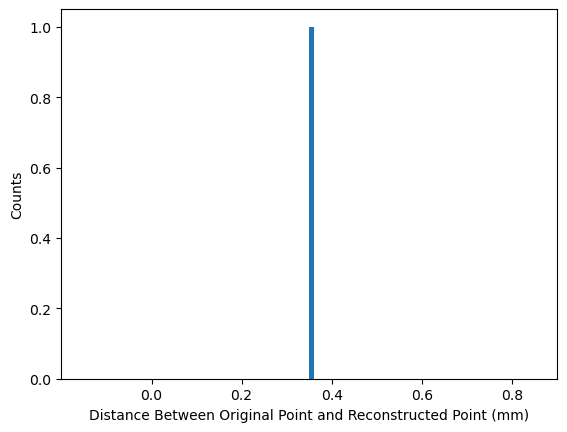

In [19]:
def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False


distances = []
for i in range(X.shape[0]):
    lines = []
    intersection_points = []
    for j in range(X.shape[1]):
        lines.append(line([X[i][j][1], X[i][j][2]], [X[i][j][4], X[i][j][5]]))
    for a in range(len(lines)):
        for b in range(a, len(lines)):
            if a == b:
                continue
            point = intersection(lines[a], lines[b])
            if point and math.dist([0, 0], point) < 600:
                intersection_points.append(point)
    average = [sum(x)/len(x) for x in zip(*intersection_points)]
    distances.append(math.dist(average, y[i][:2]))
    
print("Average Distance (mm): " + str(np.average(distances)))
print("Median Distance (mm): " + str(np.median(distances)))
    
#histogram
plt.hist(distances, bins=100)
plt.xlabel('Distance Between Original Point and Reconstructed Point (mm)')
plt.ylabel('Counts')
plt.show()

In [16]:
#reconstruction_distances = np.array(distances)
#np.savetxt('reconstruction_4_mm.csv', reconstruction_distances)